In [1]:
%pip install hcp_utils

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nibabel as nib
import nilearn.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import hcp_utils as hcp

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
#replace with your own path to the data
path='/Users/jtu/Downloads/HCP7T_retino/tfMRI_RETCCW_7T_AP.dtseries.nii'
img = nib.load(f'{path}')
X = img.get_fdata()
X.shape    

(300, 91282)

In [5]:
hcp.struct.keys()

dict_keys(['cortex_left', 'cortex_right', 'cortex', 'subcortical', 'accumbens_left', 'accumbens_right', 'amygdala_left', 'amygdala_right', 'brainStem', 'caudate_left', 'caudate_right', 'cerebellum_left', 'cerebellum_right', 'diencephalon_left', 'diencephalon_right', 'hippocampus_left', 'hippocampus_right', 'pallidum_left', 'pallidum_right', 'putamen_left', 'putamen_right', 'thalamus_left', 'thalamus_right'])

In [35]:
X_hipL = X[:, hcp.struct.cortex_left]

In [36]:
import pandas as pd
glasser_labels = pd.read_csv('Glasser.csv', header=None)
print(glasser_labels.head())

   0                              1
0  1          Primary_visual_cortex
1  2  Medial_superior_temporal_area
2  3              Sixth_Visual_Area
3  4             Second_Visual_Area
4  5              Third_Visual_Area


In [13]:
glasser_filename="~/Downloads/Q1-Q6_RelatedParcellation210.L.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii"
image=nib.load(f'{glasser_filename}')
glasser_data = image.get_fdata().squeeze()
print(glasser_data.shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(29696,)


In [8]:
glasser_labels.columns = ['Index', 'LabelName']
print(glasser_labels[['Index', 'LabelName']])

     Index                      LabelName
0        1          Primary_visual_cortex
1        2  Medial_superior_temporal_area
2        3              Sixth_Visual_Area
3        4             Second_Visual_Area
4        5              Third_Visual_Area
..     ...                            ...
175    176             Area_STSv_Anterior
176    177                Area_TE1_Middle
177    178              Para-Insular_Area
178    179         Area_Anterior_32_Prime
179    180              Area_Posterior_24

[180 rows x 2 columns]


In [14]:
v1_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Primary_visual_cortex', 'Index'].values[0]
v2_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Second_Visual_Area', 'Index'].values[0]
v3_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Third_Visual_Area', 'Index'].values[0]
print(v1_label, v2_label, v3_label)

1 4 5


In [16]:
v1_voxels = np.where(glasser_data == v1_label)[0]  
v2_voxels = np.where(glasser_data == v2_label)[0]  
v3_voxels = np.where(glasser_data == v3_label)[0]  
print(f"V1 index from {v1_voxels.min()} to {v1_voxels.max()}")
print(f"V2 index from {v2_voxels.min()} to {v2_voxels.max()}")
print(f"V3 index from {v3_voxels.min()} to {v3_voxels.max()}")

V1 index from 55 to 24020
V2 index from 65 to 24087
V3 index from 10127 to 23909


In [19]:
v1_mask = np.isin(glasser_data, v1_label)
v2_mask = np.isin(glasser_data, v2_label)
v3_mask = np.isin(glasser_data, v3_label)

In [20]:
import numpy as np

def generate_rotating_wedge_stimulus(n_frames=300,
                                     height=200,
                                     width=200,
                                     visual_field_deg=16.08,
                                     wedge_width_deg=90,
                                     cycle_duration=32,
                                     n_cycles=8,
                                     blank_duration=22,
                                     direction='ccw'):
    """
    Generates a binary stimulus matrix representing a rotating wedge stimulus.

    Parameters:
    - n_frames: total number of frames (TRs), default 300
    - height, width: spatial resolution in pixels
    - visual_field_deg: total size of visual field in degrees (assumed square)
    - wedge_width_deg: angular width of the rotating wedge
    - cycle_duration: seconds per full 360° rotation (1 cycle)
    - n_cycles: number of full cycles
    - blank_duration: seconds of blank at start and end
    - direction: 'ccw' or 'cw' (counterclockwise or clockwise)

    Returns:
    - stimulus: array of shape (n_frames, height, width) with binary apertures
    """
    # Visual field coordinate grid in degrees
    x = np.linspace(-visual_field_deg / 2, visual_field_deg / 2, width)
    y = np.linspace(-visual_field_deg / 2, visual_field_deg / 2, height)
    xv, yv = np.meshgrid(x, y)
    polar_angle = (np.arctan2(yv, xv) * 180 / np.pi) % 360  # 0 to 360

    # TRs
    tr = 1.0
    frames_per_cycle = int(cycle_duration / tr)
    blank_frames = int(blank_duration / tr)
    stimulus = np.zeros((n_frames, height, width))

    # Fill in the rotating wedge frames
    for t in range(blank_frames, n_frames - blank_frames):
        cycle_pos = (t - blank_frames) % frames_per_cycle
        angle = (360 * cycle_pos / frames_per_cycle) % 360
        if direction == 'cw':
            angle = (360 - angle) % 360  # reverse rotation

        angle_diff = (polar_angle - angle + 180) % 360 - 180
        wedge_mask = (np.abs(angle_diff) <= wedge_width_deg / 2)
        stimulus[t][wedge_mask] = 1.0

    return stimulus

# Example usage
stimulus_matrix = generate_rotating_wedge_stimulus()
print(stimulus_matrix.shape)  

(300, 200, 200)


In [21]:
def make_prf_matrix(x0_pix, y0_pix, sigma_pix, height=200, width=200):
    """
    Generate a 2D Gaussian pRF matrix over a 200x200 grid (pixel units).
    
    Parameters:
    - x0_pix, y0_pix: center of the pRF in pixels (0-199)
    - sigma_pix: standard deviation of the Gaussian in pixels
    - height, width: grid size (default 200x200)
    
    Returns:
    - prf: 2D array of shape (height, width)
    """
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xv, yv = np.meshgrid(x, y)

    prf = np.exp(-((xv - x0_pix)**2 + (yv - y0_pix)**2) / (2 * sigma_pix**2))
    return prf

In [ ]:
# fmri_file = "./hcp_retino/HCP7T_retino/tfMRI_RETCCW_7T_AP.dtseries.nii"

# # Load the file
# img = nib.load(fmri_file)
# data = img.get_fdata()
# left_cortex_data = data[:, :29696]
# print("Shape of fMRI data:", data.shape)

Shape of fMRI data: (300, 91282)


In [23]:
v1_bold = left_cortex_data[:, v1_mask]
v2_bold = left_cortex_data[:, v2_mask]
v3_bold = left_cortex_data[:, v3_mask]

In [24]:
def simulate_voxel_response(stimulus, prf):
    """
    Simulate a voxel's neural response over time by multiplying the stimulus with a pRF.

    Parameters:
    - stimulus: 3D array of shape (T, H, W), where T = timepoints (TRs)
    - prf: 2D array of shape (H, W), the pRF matrix

    Returns:
    - response: 1D array of shape (T,), predicted neural response over time
    """
    # Dot product over (H, W) for each timepoint
    response = np.tensordot(stimulus, prf, axes=([1, 2], [0, 1]))
    return response

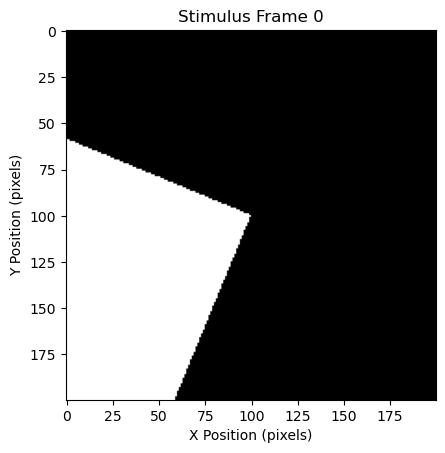

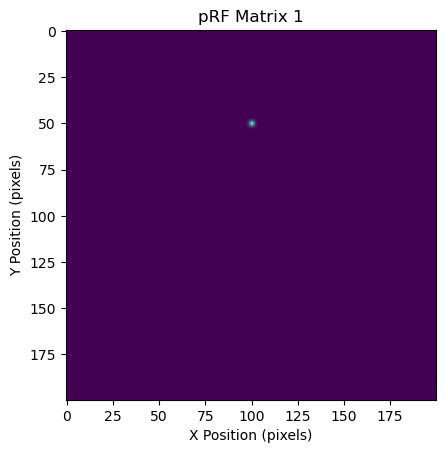

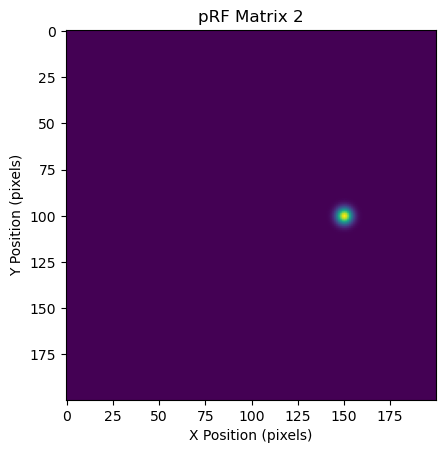

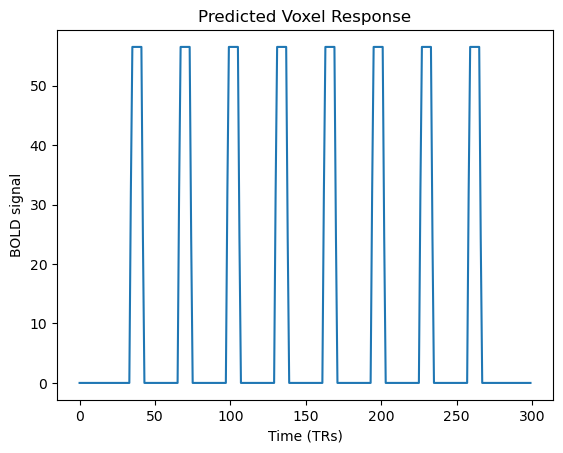

In [25]:
# Example of simulating a voxel response
prf = make_prf_matrix(x0_pix=10, y0_pix=100, sigma_pix=3)
stimulus_matrix=generate_rotating_wedge_stimulus(n_frames=300, height=200, width=200, visual_field_deg=16.08, wedge_width_deg=90, cycle_duration=32, n_cycles=8, blank_duration=22, direction='ccw')
plt.imshow(stimulus_matrix[100], cmap='gray')
plt.title("Stimulus Frame 0")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
plt.imshow(make_prf_matrix(100, 50, 1))
plt.title("pRF Matrix 1")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
plt.imshow(make_prf_matrix(150,100,3))
plt.title("pRF Matrix 2")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
predicted_response = simulate_voxel_response(stimulus_matrix, prf)
import matplotlib.pyplot as plt
plt.plot(predicted_response)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD signal")
plt.title("Predicted Voxel Response")
plt.show()

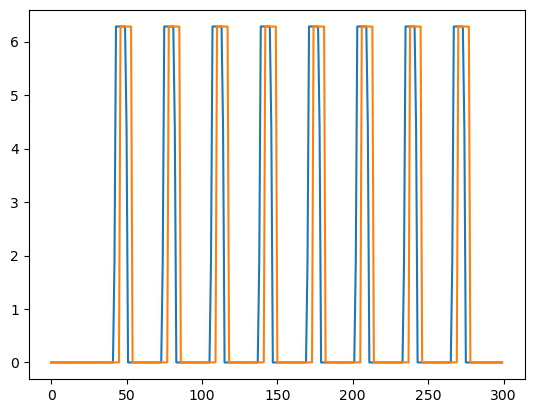

In [26]:
r1 = simulate_voxel_response(stimulus_matrix, make_prf_matrix(100, 50, 1))
r2 = simulate_voxel_response(stimulus_matrix, make_prf_matrix(150, 30, 1))
plt.plot(r1)
plt.plot(r2)

In [41]:
# Select 5 random V1 voxels
selected_indices = np.random.choice(v1_voxels, size=2, replace=False)

# Extract their BOLD time series
v1_bold_subset = X_hipL[:, selected_indices]
print(v1_bold_subset.shape)  # Should be (n_timepoints, 5)

(300, 2)


In [42]:
from nilearn.glm.first_level import spm_hrf
from scipy.signal import convolve
# HRF (canonical, TR=1s)
hrf = spm_hrf(t_r=1.0)

# Subset left hemisphere voxels (first 29696)
left_hemisphere_data = v1_bold_subset
# Search grid
x_grid = np.linspace(0, 199, 50)
y_grid = np.linspace(0, 199, 50)
sigma_grid = np.linspace(0.1, 3, 10)

# Storage
best_params = np.zeros((left_hemisphere_data.shape[1], 3))  # x0, y0, sigma
best_r2 = np.zeros(left_hemisphere_data.shape[1])

# Fit per voxel
for voxel_idx in range(left_hemisphere_data.shape[1]):
    bold_ts = left_hemisphere_data[:, voxel_idx]
    bold_ts = (bold_ts - np.mean(bold_ts)) / np.std(bold_ts)  # optional normalization

    best_score = np.inf  # for MSE
    best_rsq = -np.inf
    
    for x0 in x_grid:
        for y0 in y_grid:
            for sigma in sigma_grid:
                prf = make_prf_matrix(x0, y0, sigma)
                neural_response = simulate_voxel_response(stimulus_matrix, prf)
                bold_pred = convolve(neural_response, hrf)[:stimulus_matrix.shape[0]]

                # Optional z-score BOLD
                bold_pred = (bold_pred - np.mean(bold_pred)) / np.std(bold_pred)

                mse = np.mean((bold_ts - bold_pred) ** 2)
                
                # Convert MSE to R²
                ss_res = np.sum((bold_ts - bold_pred) ** 2)
                ss_tot = np.sum((bold_ts - np.mean(bold_ts)) ** 2)
                r2 = 1 - ss_res / ss_tot

                if mse < best_score:
                    best_score = mse
                    best_rsq = r2
                    best_params[voxel_idx] = [x0, y0, sigma]
    
    best_r2[voxel_idx] = best_rsq
    best_params[:, :2] = np.round(best_params[:, :2]).astype(int)

print("Done.")
print(best_params)

Done.
[[1.42000000e+02 1.34000000e+02 4.22222222e-01]
 [1.18000000e+02 7.70000000e+01 1.00000000e-01]]
